In [117]:
import cv2
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

CONSTANTS

In [47]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

## 1. Set GPU Memory Growth

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 2. Load in Images

### 2.1 Load in a single image and its mask

In [5]:
IMAGES_PATH = os.path.join("data", "Images")
MASKS_PATH = os.path.join("data", "Masks")

In [23]:
image_file_paths = glob.glob(IMAGES_PATH+"\\*.tif")
mask_file_paths = glob.glob(MASKS_PATH+"\\*.tif")

### 2.2 Visualize Single Image and Mask

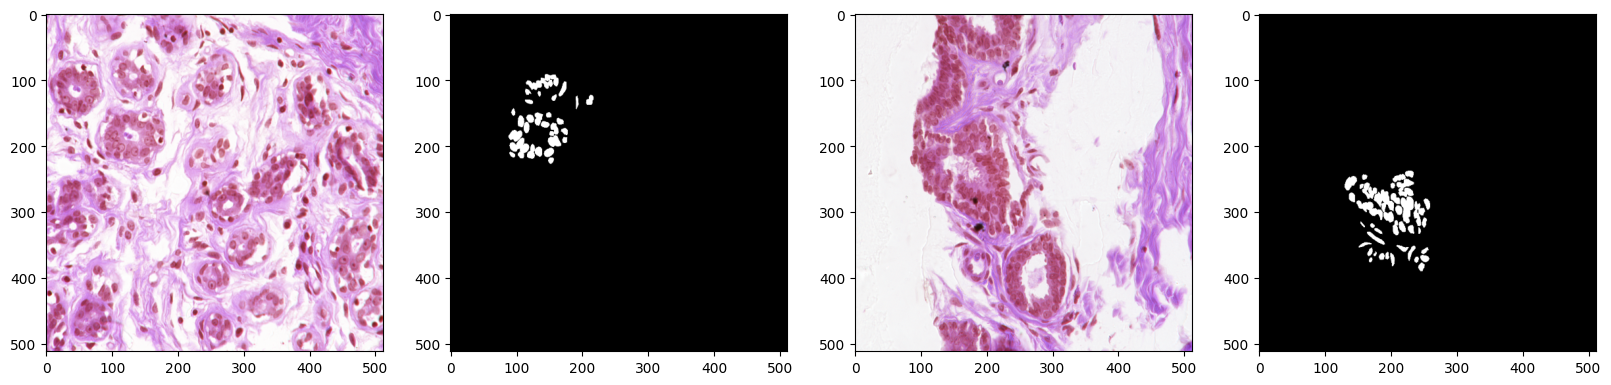

In [51]:
fig, ax = plt.subplots(ncols=4, figsize = (20,20))
for i in range(0, 3, 2):
    example_image = cv2.imread(image_file_paths[i])
    example_image = cv2.resize(example_image, (IMG_HEIGHT, IMG_WIDTH))
    example_mask = cv2.imread(mask_file_paths[i])
    example_mask = cv2.resize(example_mask, (IMG_HEIGHT, IMG_WIDTH))
    ax[i].imshow(example_image)
    ax[i+1].imshow(example_mask)

### 2.3 Preprocess Images

In [52]:
def load_images(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image/255


In [53]:
images = np.array([load_images(img_path) for img_path in image_file_paths])
masks = np.array([load_images(mask_path) for mask_path in mask_file_paths])

### 2.4 Split Data into Train and Test

In [59]:
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, train_size=0.70, random_state=42)

In [60]:
train_images.shape, test_images.shape, train_masks.shape, test_masks.shape

((40, 512, 512, 3), (18, 512, 512, 3), (40, 512, 512, 3), (18, 512, 512, 3))

### 2.5 Create Training Tensorflow Datasets

In [63]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(8)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [111]:
train_ds = train_dataset.as_numpy_iterator()

### 2.6 Visualizing Training Images and Masks

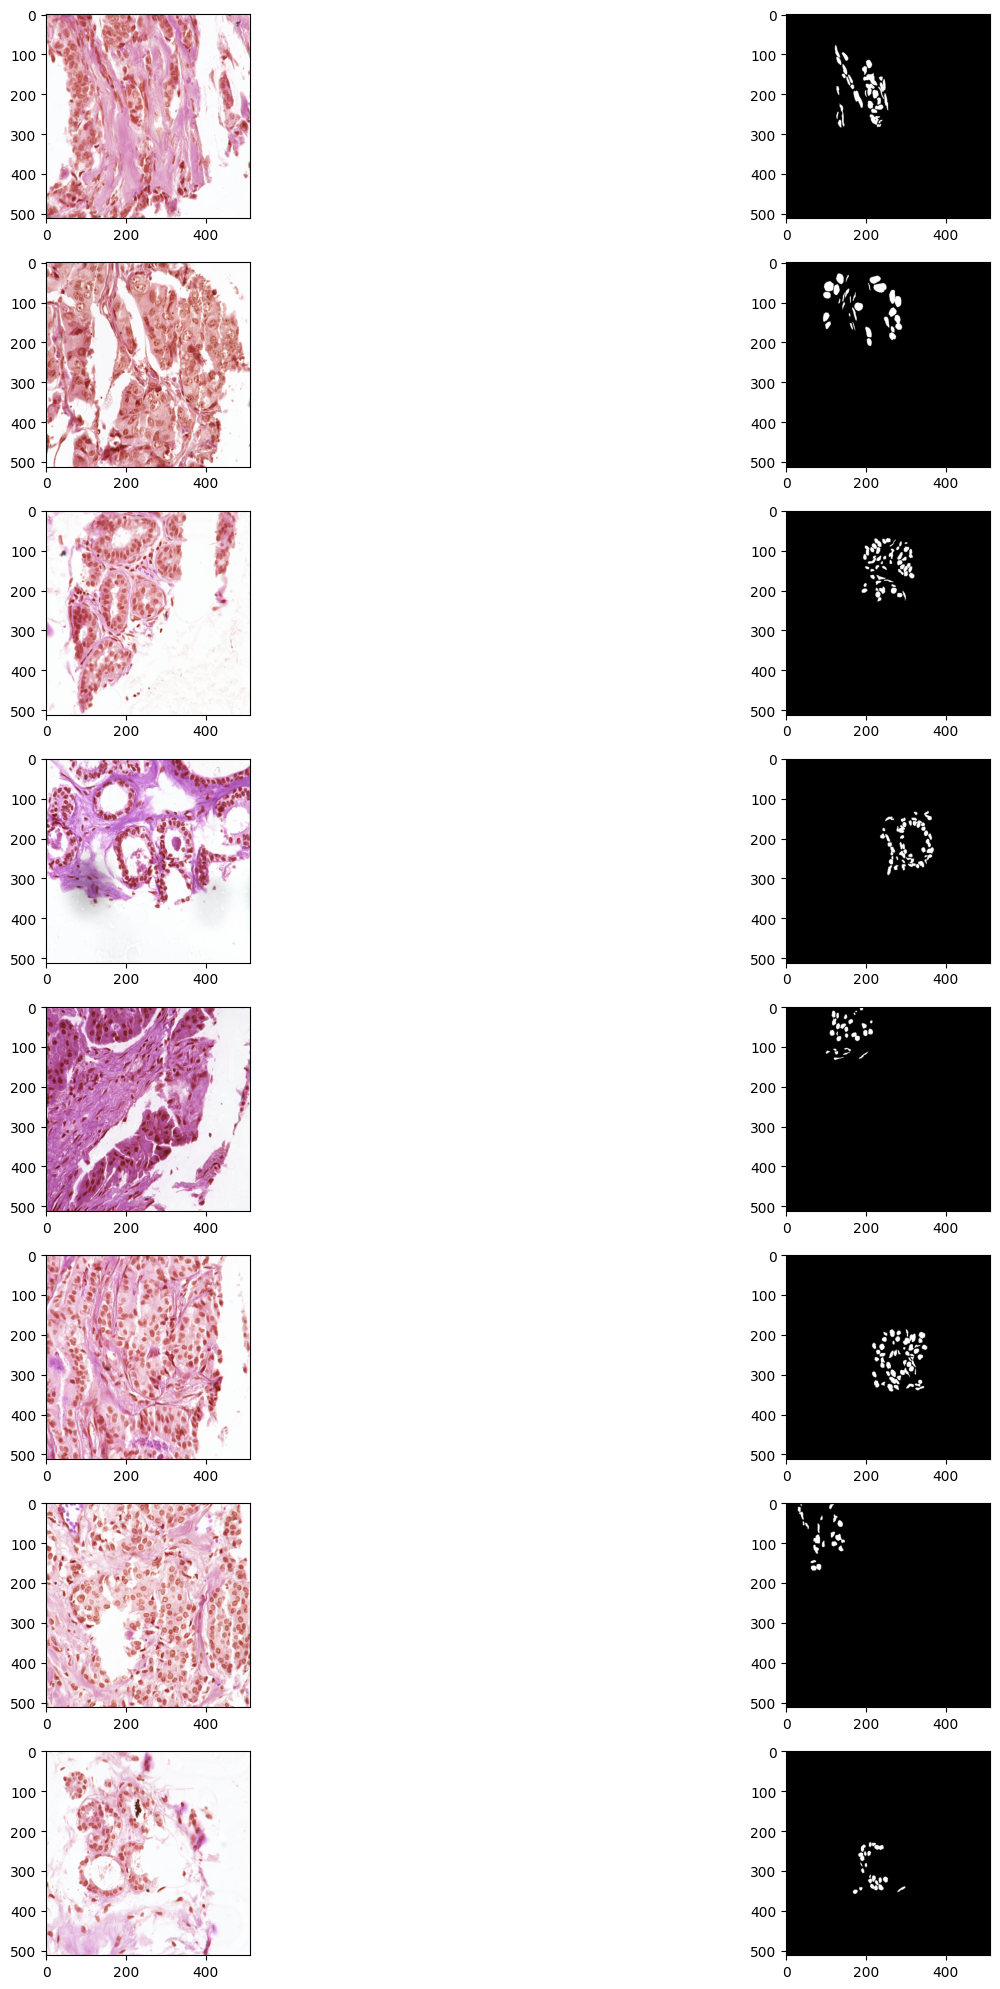

In [116]:
train_batch = train_ds.next()
fig, ax = plt.subplots(ncols = 2, nrows= 8, figsize = (20,20))
for i in range(8):
    img = train_batch[0][i]
    mask = train_batch[1][i]
    ax[i,0].imshow(img)
    ax[i,1].imshow(mask)
plt.tight_layout()
plt.show()

## 3. Creating the Model

### 3.1 Creating the U-Net Architecture